# Setup

## Install Python dependencies

In [ ]:
!python3 -m pip install numba umap-learn leidenalg scikit-learn-extra

## Imports

In [1]:
import os
import re
import umap
import umap.plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.utils.data as data_utils
from torch import nn
import torch.nn.functional as F

## Check GPU status

In [ ]:
torch.cuda.is_available()

## Paths

In [3]:
DATA_DIR = '../data'
REPRESENTATIONS_DIR = os.path.join(DATA_DIR, 'esm1b_preprs')
VAE_MODEL_DIR = os.path.join(DATA_DIR, 'vae_model')

## Other params

In [8]:
GENE_NAME = 'PDLIM3'

ALL_AAS = list('ACDEFGHIKLMNPQRSTVWY')

In [9]:
len(ALL_AAS)

20

# Parse input mutations

In [10]:
os.path.join(REPRESENTATIONS_DIR, '%s_logits.csv' % GENE_NAME)

'../data/esm1b_preprs/PDLIM3_logits.csv'

In [11]:
wt_logits = pd.read_csv(os.path.join(REPRESENTATIONS_DIR, '%s_logits.csv' % GENE_NAME), index_col = 0)\
        .rename(columns = lambda col_name : col_name.split('.')[0])
wt_ref_logits = np.array([pos_wt_logits[pos_ref_aa] for pos_ref_aa, pos_wt_logits in wt_logits.iteritems()])
LLR = (wt_logits - wt_ref_logits.reshape(1, -1)).loc[ALL_AAS]

mutation_names = np.load(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'mutation_names.npy'))
mutation_esm1b_reprs = np.load(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'mutation_reprs.npy'))

mutations = pd.DataFrame(index = mutation_names)

In [12]:
mutation_esm1b_reprs.shape

(13834, 1280)

In [13]:
LLR.shape

(20, 364)

In [14]:
mutations.shape

(13834, 0)

In [15]:
mutations['ref_index'] = [x for x in range(mutations.shape[0])]

In [16]:
mutations = mutations.loc[[gene for gene in mutations.index.tolist() if gene.split(':')[0] == GENE_NAME]]

In [17]:
mutations['name'] = [mutation_name for gene_name, mutation_name in mutations.index.str.split(':')]
mutations['pos'] = mutations['name'].apply(lambda mutation_name: np.nan if mutation_name == 'WT' else \
        int(mutation_name[1:-1]))

In [18]:
mutations.head()

,ref_index,name,pos
PDLIM3:WT,0,WT,NaN
PDLIM3:WT,6917,WT,NaN
PDLIM3:M1V,1,M1V,1.0
PDLIM3:M1V,6918,M1V,1.0
PDLIM3:M1T,2,M1T,1.0


In [19]:
mutations['alt_aa'] = mutations['name'].apply(lambda mutation_name: np.nan \
                                              if mutation_name == 'WT' else \
                                              mutation_name[-1])

In [20]:
mutations.head()

,ref_index,name,pos,alt_aa
PDLIM3:WT,0,WT,NaN,NaN
PDLIM3:WT,6917,WT,NaN,NaN
PDLIM3:M1V,1,M1V,1.0,V
PDLIM3:M1V,6918,M1V,1.0,V
PDLIM3:M1T,2,M1T,1.0,T


In [21]:
mutations['zeroshot_raw'] = mutations.apply(lambda mutation: 0 if mutation['name'] == 'WT' else \
        LLR.loc[mutation['alt_aa']].iloc[int(mutation['pos']) - 1], axis = 1)

In [22]:
mutations.head()

,ref_index,name,pos,alt_aa,zeroshot_raw
PDLIM3:WT,0,WT,NaN,NaN,0.000000
PDLIM3:WT,6917,WT,NaN,NaN,0.000000
PDLIM3:M1V,1,M1V,1.0,V,-9.761526
PDLIM3:M1V,6918,M1V,1.0,V,-9.761526
PDLIM3:M1T,2,M1T,1.0,T,-11.531293


In [23]:
zeroshot = np.clip(mutations['zeroshot_raw'], None, 0)
zeroshot -= zeroshot.min()
zeroshot /= zeroshot.max()
mutations['zeroshot'] = zeroshot

display(mutations)

,ref_index,name,pos,alt_aa,zeroshot_raw,zeroshot
PDLIM3:WT,0,WT,NaN,NaN,0.000000,1.000000
PDLIM3:WT,6917,WT,NaN,NaN,0.000000,1.000000
PDLIM3:M1V,1,M1V,1.0,V,-9.761526,0.593255
PDLIM3:M1V,6918,M1V,1.0,V,-9.761526,0.593255
PDLIM3:M1T,2,M1T,1.0,T,-11.531293,0.519512
...,...,...,...,...,...,...
PDLIM3:A364N,13831,A364N,364.0,N,-5.227101,0.782196
PDLIM3:A364D,6915,A364D,364.0,D,-8.587594,0.642171
PDLIM3:A364D,13832,A364D,364.0,D,-8.587594,0.642171
PDLIM3:A364L,6916,A364L,364.0,L,-7.281904,0.696576


Text(0, 0.5, '# mutations')

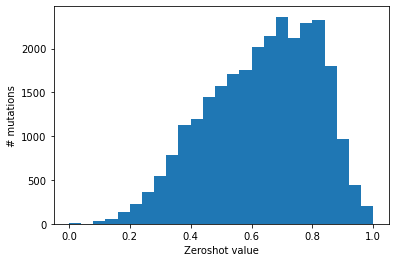

In [24]:
fig, ax = plt.subplots()
ax.hist(mutations['zeroshot'], bins = 25)
ax.set_xlabel('Zeroshot value')
ax.set_ylabel('# mutations')

In [149]:
# mutations['ref_index'].tolist()

In [29]:
X = StandardScaler().fit_transform(mutation_esm1b_reprs[mutations['ref_index'].tolist(),:])

# Train a low-dimensional auto-encoder

## Params

In [25]:
PARAMS = {
    'input_dim': 1280,
    'intermediate_dim': 128,
    'latent_dim': 15,
    'kl_weight': 0.1,
    'pred_weight': 50,
    'batch_size': 512,
    'train_size': 0.8,
    'n_epochs': 400,
    'lr': 1e-03,
}

## Define and train the model

In [30]:
class VAE(nn.Module):
    
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        
        nn.Module.__init__(self)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim

        # Encoder
        self.input_enc = nn.Linear(in_features = self.input_dim, out_features = self.intermediate_dim)
        self.batch_norm_enc = nn.BatchNorm1d(self.intermediate_dim)
        self.drop_enc = nn.Dropout(p = 0.05)
        self.mu_enc = nn.Linear(in_features = self.intermediate_dim, out_features = self.latent_dim)
        self.logvar_enc = nn.Linear(in_features = self.intermediate_dim, out_features = self.latent_dim)
 
        # Decoder 
        self.latent_dec = nn.Linear(in_features = self.latent_dim, out_features = self.intermediate_dim)
        self.batch_norm_dec = nn.BatchNorm1d(self.intermediate_dim)
        self.drop_dec = nn.Dropout(p = 0.05)
        self.out_dec = nn.Linear(in_features = self.intermediate_dim, out_features = self.input_dim)
        self.y_dec = nn.Linear(in_features = self.latent_dim, out_features = 1, bias = False)
                
    def encode(self, x):
        x = self.drop_enc(F.relu(self.batch_norm_enc(self.input_enc(x))))
        x_mu = self.mu_enc(x)
        x_logvar = self.logvar_enc(x)
        return x_mu, x_logvar
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        r = torch.randn_like(std)
        z = mu + r * std
        return z
    
    def decode(self, z):
        return self.out_dec(self.drop_dec(F.relu(self.batch_norm_dec(self.latent_dec(z)))))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var
    
    def predict(self, x_mu):
        return self.y_dec(x_mu)
    
    def loss_mse(self, x, x_hat):
        return F.mse_loss(x_hat, x, reduction = 'sum') / x.shape[0]
    
    def loss_kld(self, mu, log_var):
        # KL divergence between the distribution determined by the encoder (by mu and log_var) and the standard normal
        # distribution N(0, 1):
        # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / mu.shape[0]
    
    def loss_pred(self, mu, y):
        return F.mse_loss(self.predict(mu), y, reduction = 'sum') / mu.shape[0]

In [31]:
class DummyWith:
    
    def __enter__(self, *args):
        pass
    
    def __exit__(self, *args):
        pass

def run_model(model, data_loader, fit = True, optimizer = None, labeled = False, kl_weight = 1, pred_weight = 1, \
        device = 'cuda'):
    
    if fit:
        model.train()
    else:
        model.eval()
    
    n_batches = 0
    total_loss = 0.0
    total_loss_mse = 0.0
    total_loss_kld = 0.0
    total_loss_pred = 0.0
    
    with (DummyWith() if fit else torch.no_grad()):
        for i, batch_data in enumerate(data_loader):

            n_batches += 1

            if labeled:
                x, y = batch_data
                x = x.to(device)
                y = y.to(device)
            else:
                x = batch_data
                x = x.to(device)
                y = None
            
            if fit:
                optimizer.zero_grad()
            
            x_hat, mu, log_var = model(x)

            batch_loss_mse = model.loss_mse(x, x_hat)
            total_loss_mse += batch_loss_mse
            batch_loss_kld = model.loss_kld(mu, log_var)
            total_loss_kld += batch_loss_kld
            batch_loss = batch_loss_mse + kl_weight * batch_loss_kld

            if labeled:
                batch_loss_pred = model.loss_pred(mu, y)
                total_loss_pred += batch_loss_pred
                batch_loss += pred_weight * batch_loss_pred

            total_loss += batch_loss

            if fit:
                batch_loss.backward()
                optimizer.step()
        
    total_loss /= n_batches
    total_loss_mse /= n_batches
    total_loss_kld /= n_batches
    total_loss_pred /= n_batches
    
    return total_loss, total_loss_mse, total_loss_kld, total_loss_pred

In [32]:
y = mutations['zeroshot_raw'].values.reshape(-1, 1)
dataset = data_utils.TensorDataset(torch.tensor(X), torch.tensor(y, dtype = torch.float32))
train_set, valid_set = train_test_split(dataset, train_size = PARAMS['train_size'])

train_loader = data_utils.DataLoader(train_set, batch_size = PARAMS['batch_size'], shuffle = True)
valid_loader = data_utils.DataLoader(valid_set, batch_size = PARAMS['batch_size'], shuffle = False)

model = VAE(input_dim = PARAMS['input_dim'], intermediate_dim = PARAMS['intermediate_dim'], \
        latent_dim = PARAMS['latent_dim']).to('cuda')
n_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# trainable parameters: %.1g' % n_total_params)

optimizer = torch.optim.Adam(model.parameters(), lr = PARAMS['lr'])

for epoch in range(PARAMS['n_epochs']):
    
    train_loss, train_loss_mse, train_loss_kld, train_loss_pred = run_model(model, train_loader, fit = True, \
            optimizer = optimizer, labeled = True, kl_weight = PARAMS['kl_weight'], pred_weight = PARAMS['pred_weight'])
    valid_loss, valid_loss_mse, valid_loss_kld, valid_loss_pred = run_model(model, train_loader, fit = False, \
            labeled = True, kl_weight = PARAMS['kl_weight'], pred_weight = PARAMS['pred_weight'])
    
    if epoch % 10 == 0: 
        print(('Epoch %d/%d: training loss = %.2g (MSE = %.2g, KLD = %.2g, pred = %.2g), ' + \
                'validation loss = %.2g (MSE = %.2g, KLD = %.2g, pred = %.2g)') % (epoch, PARAMS['n_epochs'], train_loss, \
                train_loss_mse, train_loss_kld, train_loss_pred, valid_loss, valid_loss_mse, valid_loss_kld, \
                valid_loss_pred), end = '\n' if epoch % 100 == 0 else '\r')
        
print('Done.')

# trainable parameters: 3e+05
Epoch 0/400: training loss = 3.8e+03 (MSE = 1.2e+03, KLD = 24, pred = 51), validation loss = 1.8e+03 (MSE = 1.1e+03, KLD = 65, pred = 14)
Epoch 100/400: training loss = 5.2e+02 (MSE = 4.9e+02, KLD = 89, pred = 0.38), validation loss = 4.6e+02 (MSE = 4.4e+02, KLD = 88, pred = 0.22)0.2)19)5)
Epoch 200/400: training loss = 5e+02 (MSE = 4.8e+02, KLD = 79, pred = 0.31), validation loss = 4.3e+02 (MSE = 4.2e+02, KLD = 79, pred = 0.12)))
Epoch 300/400: training loss = 4.9e+02 (MSE = 4.7e+02, KLD = 74, pred = 0.27), validation loss = 4.2e+02 (MSE = 4.1e+02, KLD = 74, pred = 0.074)
Done. 390/400: training loss = 4.9e+02 (MSE = 4.7e+02, KLD = 72, pred = 0.28), validation loss = 4.2e+02 (MSE = 4e+02, KLD = 71, pred = 0.094)))


In [36]:
# os.mkdir(VAE_MODEL_DIR)
torch.save(model.state_dict(), os.path.join(VAE_MODEL_DIR, GENE_NAME + '_model.pt'))

## Calculate the embeddings and distance from WT for all mutations

In [37]:
high_D_dataset_loader = data_utils.DataLoader(torch.tensor(X, dtype = torch.float32), batch_size = PARAMS['batch_size'], \
        shuffle = False)
low_D_embeddings = []

with torch.no_grad():
    for batch in high_D_dataset_loader:
        x_mu, _ = model.encode(batch.to(0))
        low_D_embeddings.append(x_mu.cpu().numpy())

low_D_embeddings = np.vstack(low_D_embeddings)
print(low_D_embeddings.shape)

assert mutations.iloc[0]['name'] == 'WT'
WT_low_D_embeddings = low_D_embeddings[0]
mutations['dist_from_WT'] = np.linalg.norm(low_D_embeddings - WT_low_D_embeddings, axis = 1)
display(mutations)

(27668, 15)


,ref_index,name,pos,alt_aa,zeroshot_raw,zeroshot,dist_from_WT
PDLIM3:WT,0,WT,NaN,NaN,0.000000,1.000000,0.000000
PDLIM3:WT,6917,WT,NaN,NaN,0.000000,1.000000,0.000000
PDLIM3:M1V,1,M1V,1.0,V,-9.761526,0.593255,6.826495
PDLIM3:M1V,6918,M1V,1.0,V,-9.761526,0.593255,6.826495
PDLIM3:M1T,2,M1T,1.0,T,-11.531293,0.519512,7.365092
...,...,...,...,...,...,...,...
PDLIM3:A364N,13831,A364N,364.0,N,-5.227101,0.782196,3.256585
PDLIM3:A364D,6915,A364D,364.0,D,-8.587594,0.642171,4.246437
PDLIM3:A364D,13832,A364D,364.0,D,-8.587594,0.642171,4.246437
PDLIM3:A364L,6916,A364L,364.0,L,-7.281904,0.696576,3.030806


In [38]:
np.save(os.path.join(REPRESENTATIONS_DIR, GENE_NAME, 'VAE_embeddings.npy'), low_D_embeddings)

# Run UMAP

In [39]:
reducer = umap.UMAP(spread = 2, min_dist = 0.1, n_components = 2, random_state = 0)
umap_embeddings = reducer.fit_transform(low_D_embeddings)
mutations['umap1'] = umap_embeddings[:, 0]
mutations['umap2'] = umap_embeddings[:, 1]
print('Done.')

/wynton/home/bruneau/ablair/.conda/envs/VariantFx/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:339: UserWarning: Exited at iteration 2000 with accuracies 
[7.04185482e-15 9.12788507e-07 6.78373602e-07 1.83893924e-06]
not reaching the requested tolerance 1e-15.
  _, diffusion_map = lobpcg(laplacian, X, tol=1e-15,
/wynton/home/bruneau/ablair/.conda/envs/VariantFx/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/wynton/home/bruneau/ablair/.conda/envs/VariantFx/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/wynt

Done.


In [40]:
mutations.to_csv('../data/vae_model/' + GENE_NAME +'_umap.csv')

In [196]:
mutations.corr(method = 'spearman')

,ref_index,pos,zeroshot_raw,zeroshot,dist_from_WT,umap1,umap2
ref_index,1.000000,0.999995,0.010914,0.010910,-0.024894,0.012830,-0.091401
pos,0.999995,1.000000,0.011599,0.011597,-0.025655,0.013389,-0.091077
zeroshot_raw,0.010914,0.011599,1.000000,1.000000,-0.954242,0.564800,0.612905
zeroshot,0.010910,0.011597,1.000000,1.000000,-0.954242,0.564799,0.612905
dist_from_WT,-0.024894,-0.025655,-0.954242,-0.954242,1.000000,-0.540820,-0.558859
umap1,0.012830,0.013389,0.564800,0.564799,-0.540820,1.000000,0.309913
umap2,-0.091401,-0.091077,0.612905,0.612905,-0.558859,0.309913,1.000000


# Incorporate ClinVar labels

## Download the data from the EVE paper

In [18]:
!mkdir /data/eve
#!wget https://evemodel.org/api/proteins/bulk/download/ -O /data/eve/all_data.zip
!aws s3 cp s3://ucsf-genomics-prod-project-data/nadavb/variant_func_project/eve_all_data.zip /data/eve/all_data.zip

mkdir: cannot create directory ‘/data/eve’: No such file or directory
/bin/bash: aws: command not found


In [3]:
!cd /data/eve/; unzip -q all_data.zip

In [4]:
!rm -f /data/eve/all_data.zip

## Parse and merge the ClinVar annotations

In [20]:
CLINVAR_LABEL_MAPPING = {
    'Pathogenic': 1,
    'Likely pathogenic': 1,
    'Pathogenic/Likely pathogenic': 1,
    'Benign': 0,
    'Likely benign': 0,
    'Benign/Likely benign': 0,
}

gene_eve_variants = pd.read_csv('/data/eve/variant_files/%s_HUMAN.csv' % GENE_NAME)
gene_eve_variants['clinvar_label'] = gene_eve_variants['ClinVar_ClinicalSignificance'].map(CLINVAR_LABEL_MAPPING)
gene_eve_variants = gene_eve_variants[['position', 'mt_aa', 'clinvar_label']].dropna().rename(columns = \
        {'position': 'pos', 'mt_aa': 'alt_aa'})

mutations = mutations.merge(gene_eve_variants, how = 'left')
display(mutations)

,name,pos,alt_aa,zeroshot_raw,zeroshot,dist_from_WT,umap1,umap2,clinvar_label
0,WT,NaN,NaN,0.000000,1.000000,0.000000,13.389468,14.171518,NaN
1,M1R,1.0,R,-7.114298,0.664651,8.338156,-10.913335,14.594166,NaN
2,M1I,1.0,I,-7.966370,0.624487,7.533703,-10.954249,14.553136,NaN
3,M1Q,1.0,Q,-7.221487,0.659598,8.007198,-10.918446,14.589292,NaN
4,M1L,1.0,L,-6.494941,0.693846,7.881412,-10.896154,14.611818,NaN
...,...,...,...,...,...,...,...,...,...
7463,D393T,393.0,T,-5.684109,0.732066,5.086281,-4.489617,6.494355,NaN
7464,D393S,393.0,S,-4.304160,0.797113,3.958877,-4.381223,6.568574,NaN
7465,D393E,393.0,E,-4.249734,0.799679,2.351478,11.219969,14.412282,NaN
7466,D393A,393.0,A,-5.553951,0.738202,5.208440,-4.541315,6.440642,NaN


## Get clusters from the Ursu et al. paper

In [28]:
!wget https://www.biorxiv.org/content/biorxiv/early/2020/11/17/2020.11.16.383307/DC2/embed/media-2.xlsx?download=true -O /data/ursu_supp_table2.xlsx

--2021-12-07 16:38:19--  https://www.biorxiv.org/content/biorxiv/early/2020/11/17/2020.11.16.383307/DC2/embed/media-2.xlsx?download=true
Resolving www.biorxiv.org (www.biorxiv.org)... 104.18.9.18, 104.18.8.18
Connecting to www.biorxiv.org (www.biorxiv.org)|104.18.9.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘/data/ursu_supp_table2.xlsx’

/data/ursu_supp_tab     [ <=>                ]  16.67K  --.-KB/s    in 0.001s  

2021-12-07 16:38:19 (12.0 MB/s) - ‘/data/ursu_supp_table2.xlsx’ saved [17067]



In [21]:
ursu_variants = pd.read_excel('/data/ursu_supp_table2.xlsx')
ursu_variants = ursu_variants.loc[ursu_variants['Mutation type'] == 'Single', ['Variant', 'Variant functional class']]\
        .dropna().rename(columns = {'Variant': 'name', 'Variant functional class': 'ursu_cluster'})
mutations = mutations.merge(ursu_variants, how = 'left')
display(mutations)

FileNotFoundError: [Errno 2] No such file or directory: '/data/ursu_supp_table2.xlsx'

# Make UMAP plots

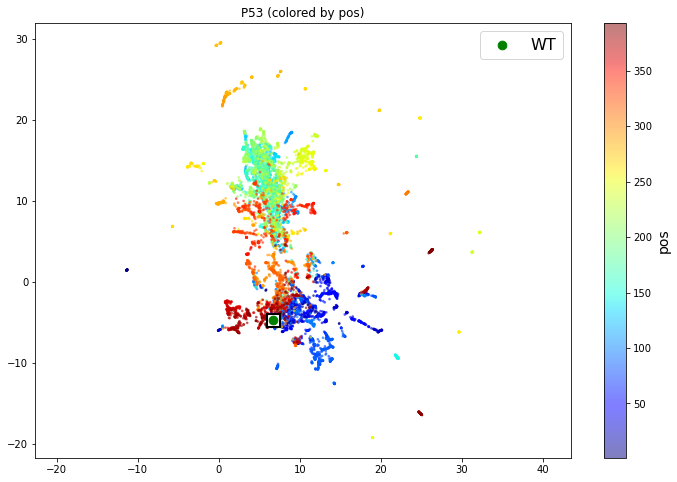

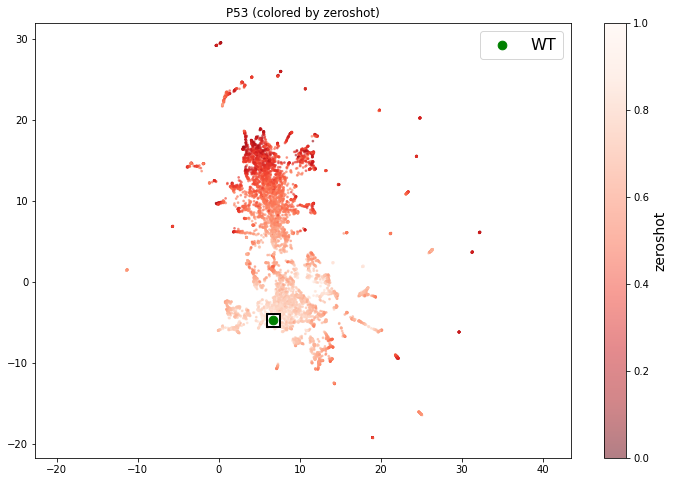

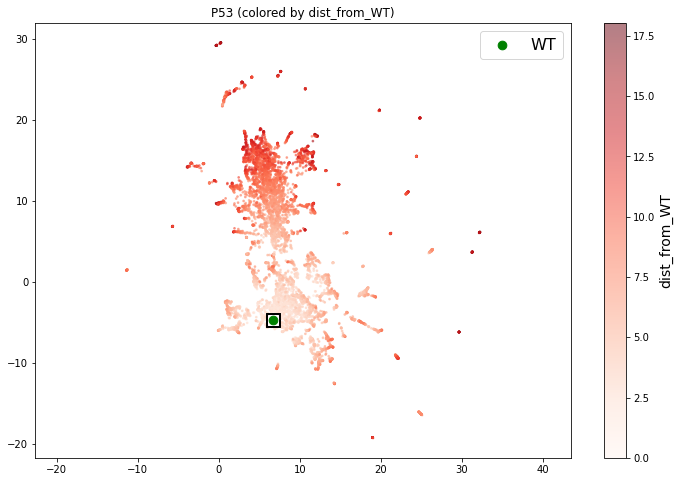

In [19]:
WT_STYLES = [
    dict(c = 'black', s = 200, marker = 's'),
    dict(c = 'white', s = 100, marker = 's'),
    dict(c = 'green', s = 75, label = 'WT'),
]

COLOR_SCHEMES = [
    # color_field, cmap
    ('pos', 'jet'),
    ('zeroshot', 'Reds_r'),
    ('dist_from_WT', 'Reds'),
]

(_, WT_mutation), = mutations[mutations['name'] == 'WT'].iterrows()

for color_field, cmap in COLOR_SCHEMES:
    
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.set_aspect('equal', 'datalim')
    ax.set_title('%s (colored by %s)' % (GENE_NAME, color_field))

    relevant_mutations = mutations.dropna(subset = ['zeroshot'])
    scatter_plot = ax.scatter(relevant_mutations['umap1'], relevant_mutations['umap2'], \
            c = relevant_mutations[color_field], cmap = cmap, s = 3, alpha = 0.5)
    colorbar = fig.colorbar(scatter_plot)
    colorbar.set_label(color_field, fontsize = 14)

    for wt_style in WT_STYLES:
        plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

    ax.legend(fontsize = 16)

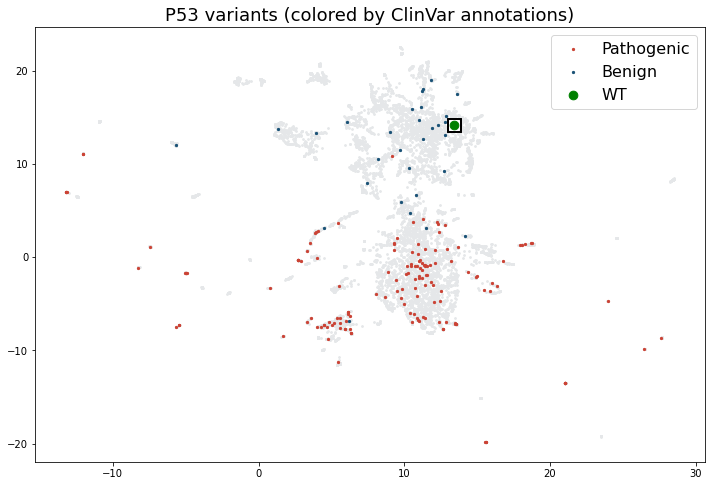

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.set_title('%s variants (colored by ClinVar annotations)' % GENE_NAME, fontsize = 18)

ax.scatter(mutations['umap1'], mutations['umap2'], s = 3, color = '#E5E7E9')
ax.scatter(mutations.loc[mutations['clinvar_label'] == 1, 'umap1'], mutations.loc[mutations['clinvar_label'] == 1, \
        'umap2'], s = 5, color = '#CB4335', label = 'Pathogenic')
ax.scatter(mutations.loc[mutations['clinvar_label'] == 0, 'umap1'], mutations.loc[mutations['clinvar_label'] == 0, \
        'umap2'], s = 5, color = '#1A5276', label = 'Benign')

for wt_style in WT_STYLES:
    plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

ax.legend(fontsize = 16)

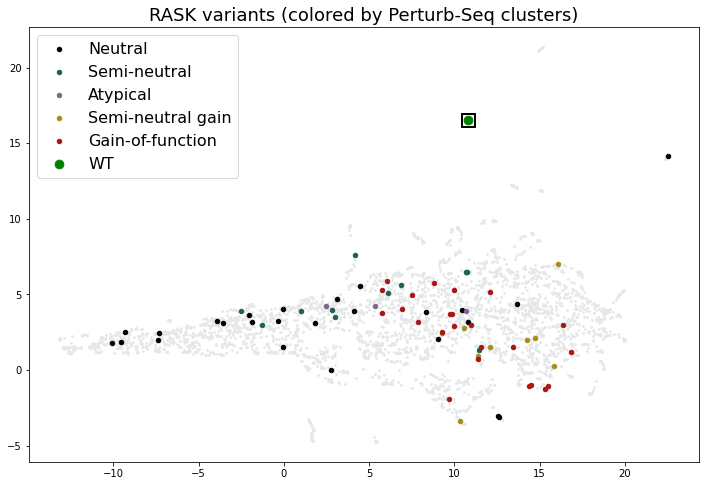

In [62]:
URSU_CLUSTER_TO_COLOR = {
    'Neutral': '#000000',
    'Semi-neutral': '#1E6151',
    'Atypical': '#80648E',
    'Semi-neutral gain': '#A68D22',
    'Gain-of-function': '#AB1513',
}

fig, ax = plt.subplots(figsize = (12, 8))
ax.set_title('%s variants (colored by Perturb-Seq clusters)' % GENE_NAME, fontsize = 18)

ax.scatter(mutations['umap1'], mutations['umap2'], s = 3, color = '#E5E7E9')

for cluster, color in URSU_CLUSTER_TO_COLOR.items():
    cluster_mutations = mutations[mutations['ursu_cluster'] == cluster]
    ax.scatter(cluster_mutations['umap1'], cluster_mutations['umap2'], s = 20, color = color, label = cluster)

for wt_style in WT_STYLES:
    plt.scatter(WT_mutation['umap1'], WT_mutation['umap2'], **wt_style)

ax.legend(fontsize = 16)